
# <span style="color:rgb(213,80,0)">Simulation with Surface Electrolyte Interface (SEI)</span>

For the SEI, we use the model described in the paper *Microstructure\-resolved degradation simulation of lithium\-ion batteries in space applications* from Bolay et al. ([https://doi.org/10.1016/j.powera.2022.100083](https://doi.org/10.1016/j.powera.2022.100083)).


The model consider the electron diffusion and migration in the SEI layer given by the flux


$$N_{sei} =D^{e^{-1} } \frac{c^{e^{-1} } }{L_{sei} }-zF\kappa_{sei}^{e^{-1} } \nabla \phi$$

-  $D^{e^- }$ : Electron iffusion coefficient
-  $c^{e^- }$ : Electron concentration
-  $L_{sei}$ : SEI length
-  $\kappa_{sei}^{e^- }$ : Electronic conductivity in SEI

When the electron reaches the SEI interface, it reacts with the electrolyte to create more SEI. This process is modeled by the differential equation


$$\frac{1}{V_{sei} }\frac{dL_{sei} }{dt}=N_{sei}$$

where

-  $V_{sei}$ : Mean partial volume of SEI

The SEI layer induces an additional potential drop given by


$$U_{sei} =\frac{L_{sei} }{\kappa_{Li^+ }^{sei} }j_{Li^+ }$$

where

-  $\kappa_{Li^+ }^{sei}$ : Conductivity for Lithium ion in SEI
-  $j_{Li^+ }$ : Lithium ion current density

We define some shortcuts for convenience


In [1]:
ne    = 'NegativeElectrode';
pe    = 'PositiveElectrode';
am    = 'ActiveMaterial';
co    = 'Coating';
sd    = 'SolidDiffusion';
itf   = 'Interface';
sei   = 'SolidElectrodeInterface';
sr    = 'SideReaction';
elyte = 'Electrolyte';
ctrl  = 'Control';

## Setup the properties of the Li\-ion battery materials and of the cell design

We use a standard parameter set


In [2]:
jsonfilename = fullfile('ParameterData', 'BatteryCellParameters', 'LithiumIonBatteryCell', ...
                        'lithium_ion_battery_nmc_graphite.json');
jsonstruct = parseBattmoJson(jsonfilename);


We do not include the thermal effect in this simulation


In [3]:
jsonstruct.use_thermal = false;


We parse and add to our json input structure <samp>jsonstruct</samp> the parameters for the SEI model


In [4]:
jsonfilename = fullfile('ParameterData', 'ParameterSets', 'Bolay2022', 'bolay_sei_interface.json');
jsonstruct_bolay = parseBattmoJson(jsonfilename);

jsonstruct.(ne).(co).(am) = mergeJsonStructs({jsonstruct.(ne).(co).(am), ...
                                              jsonstruct_bolay});


We create a control structure which we add to the main json structure


In [5]:
jsontruct_control = struct( 'controlPolicy'     , 'CCCV'       , ...
                            'initialControl'    , 'discharging', ...
                            'numberOfCycles'    , 4            , ...
                            'CRate'             , 1            , ...
                            'DRate'             , 1            , ...
                            'lowerCutoffVoltage', 3            , ...
                            'upperCutoffVoltage', 4            , ...
                            'dIdtLimit'         , 1e-4         , ...
                            'dEdtLimit'         , 1e-4);

jsonstruct.(ctrl) = jsontruct_control;

jsonstruct.SOC = 1;


We parse and add to <samp>jsonstruct</samp> some geometrical parameter. Here, we use a P2D model


In [6]:
jsonfilename = fullfile('Examples', 'JsonDataFiles', 'geometry1d.json');
jsontruct_geometry = parseBattmoJson(jsonfilename);

jsonstruct = mergeJsonStructs({jsonstruct, jsontruct_geometry});

## Simulation

We run the simulation


In [7]:
output = runBatteryJson(jsonstruct);

## Plotting

We recover the states and the model from the <samp>output</samp> structure


In [8]:
states = output.states;
model  = output.model;
time   = output.time;
E      = output.E;
I      = output.I;

for istate = 1 : numel(states)
    states{istate} = model.addVariables(states{istate});
end

close all

set(0, 'defaultlinelinewidth', 3)
set(0, 'defaultaxesfontsize', 15)



We plot the voltage



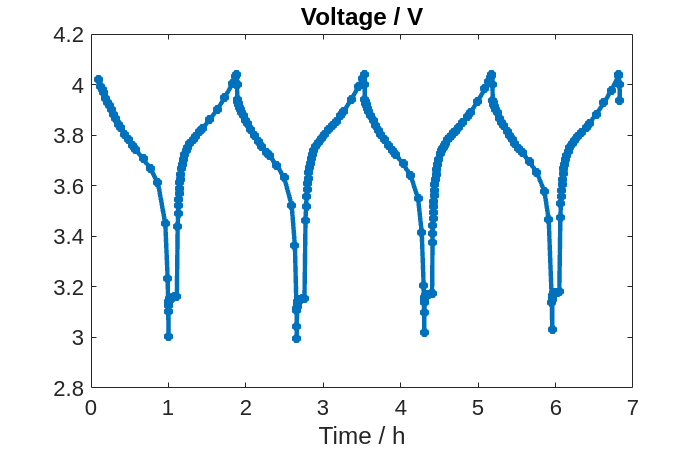

In [9]:
figure
plot(time/hour, E, '*-');
title('Voltage / V')
xlabel('Time / h')


We plot the current



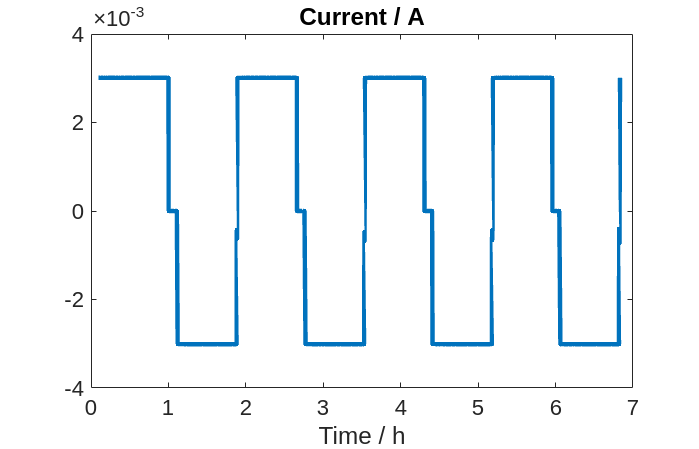

In [10]:
figure
plot(time/hour, I);
title('Current / A')
xlabel('Time / h')

## SEI thickness

We plot the evolution of the SEI thickness in the negative electrode



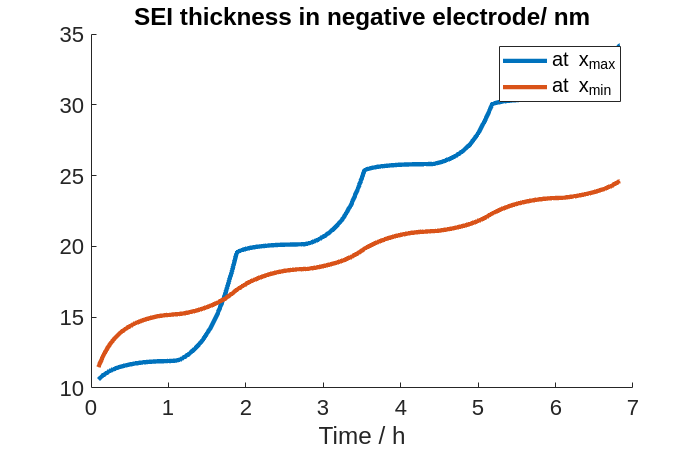

In [11]:
figure
hold on

delta = cellfun(@(state) state.(ne).(co).(am).(itf).SEIlength(end), states);
plot(time/hour, delta/(nano*meter), 'displayname', 'at x_{max}')

delta = cellfun(@(state) state.(ne).(co).(am).(itf).SEIlength(1), states);
plot(time/hour, delta/(nano*meter), 'displayname', 'at x_{min}')

title('SEI thickness in negative electrode/ nm')
xlabel('Time / h')

legend show

## SEI voltage drop

We plot the evolution of the voltage drop



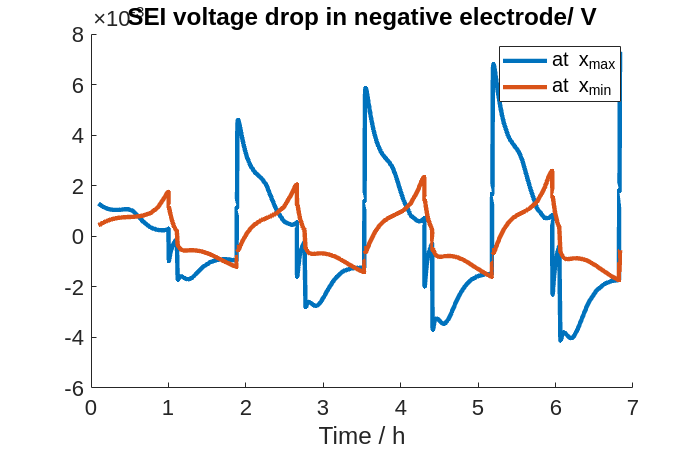

In [12]:
figure
hold on

u = cellfun(@(state) state.(ne).(co).(am).(itf).SEIvoltageDrop(end), states);
plot(time/hour, u, 'displayname', 'at x_{max}')

u = cellfun(@(state) state.(ne).(co).(am).(itf).SEIvoltageDrop(1), states);
plot(time/hour, u, 'displayname', 'at x_{min}')

title('SEI voltage drop in negative electrode/ V')
xlabel('Time / h')
legend show

## Lithium content

We plot the evolution of the lithium content in the negative electrode



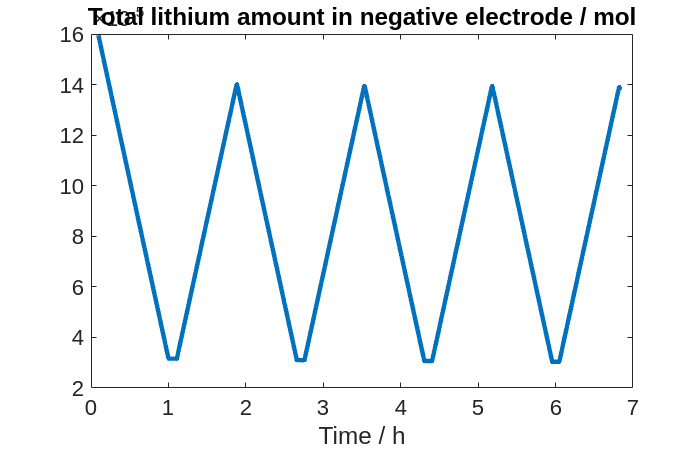

In [13]:
figure

vols = model.(ne).(co).G.getVolumes();

for istate = 1 : numel(states)
    state = states{istate};
    state = model.evalVarName(state, {ne, co, am, itf, 'SEIconcentration'});
    m(istate) = sum(vols.*state.(ne).(co).(am).(sd).cAverage);
end

plot(time/hour, m);
title('Total lithium amount in negative electrode / mol')
xlabel('Time / h')

## Lithium total mass balance

We plot the Lithium content in all the components



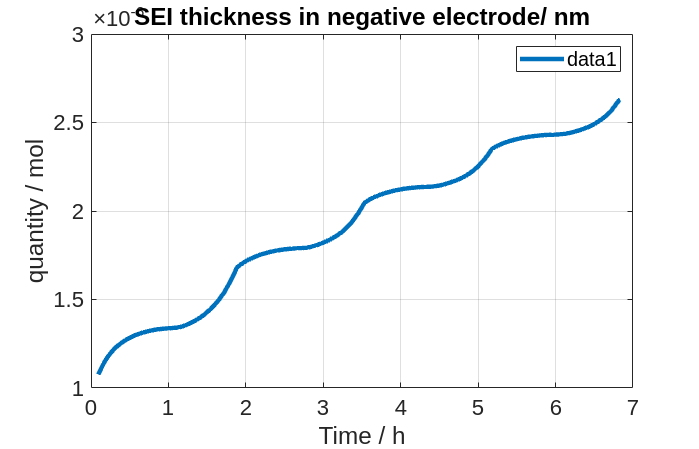

In [14]:
quantities = [];

vols = model.(ne).(co).G.getVolumes();

for timeindex = 1 : numel(states)

    state = states{timeindex};
    state = model.evalVarName(state, {ne, co, am, itf, 'SEIconcentration'});
    cSEI  = state.(ne).(co).(am).(itf).SEIconcentration;

    Liqqt = sum(cSEI.*vols);
    quantities(end + 1) = Liqqt;

end

figure
plot(time/hour, quantities);
title('Lithium quantity consummed');
xlabel('Time / h');
ylabel('quantity / mol');
grid on;

PE_Li_quantities          = [];
NE_Li_quantities          = [];
Electrolyte_Li_quantities = [];
Electrodes_Li_quantities  = [];
Total_Li_quantities       = [];

for timeindex = 1 : numel(states)

    amvf     = model.(pe).(co).volumeFractions(1);
    vf       = model.(pe).(co).volumeFraction;
    vols     = model.(pe).G.getVolumes;
    cAverage = states{timeindex}.(pe).(co).(am).(sd).cAverage;

    PE_qtt = sum(amvf.*vf.*vols.*cAverage);

    amvf     = model.(ne).(co).volumeFractions(1);
    vf       = model.(ne).(co).volumeFraction;
    vols     = model.(ne).G.getVolumes;
    cAverage = states{timeindex}.(ne).(co).(am).(sd).cAverage;

    NE_qtt = sum(amvf.*vf.*vols.*cAverage);

    Elyte_qtt = sum(model.Electrolyte.volumeFraction.*model.Electrolyte.G.getVolumes.*states{timeindex}.Electrolyte.c);

    Elode_qtt = PE_qtt + NE_qtt;
    Tot_Liqqt = PE_qtt + NE_qtt + Elyte_qtt;

    PE_Li_quantities(end + 1)          = PE_qtt;
    NE_Li_quantities(end + 1)          = NE_qtt;
    Electrolyte_Li_quantities(end + 1) = Elyte_qtt;
    Electrodes_Li_quantities(end + 1)  = Elode_qtt;
    Total_Li_quantities(end + 1)       = Tot_Liqqt;
end

title('SEI thickness in negative electrode/ nm')
xlabel('Time / h')

legend show


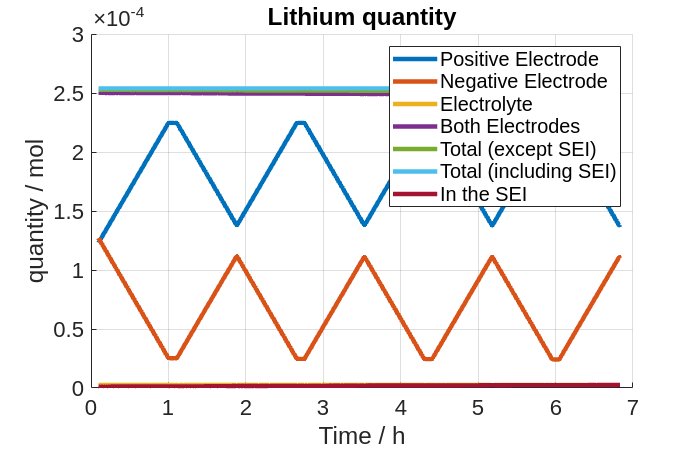

In [15]:
figure
hold on

plot(time/hour, PE_Li_quantities                ,'DisplayName','Positive Electrode');
plot(time/hour, NE_Li_quantities                ,'DisplayName','Negative Electrode');
plot(time/hour, Electrolyte_Li_quantities       ,'DisplayName','Electrolyte');
plot(time/hour, Electrodes_Li_quantities        ,'DisplayName','Both Electrodes');
plot(time/hour, Total_Li_quantities             ,'DisplayName','Total (except SEI)');
plot(time/hour, Total_Li_quantities + quantities,'DisplayName','Total (including SEI)');
plot(time/hour, quantities                      ,'DisplayName','In the SEI');
title('Lithium quantity');
xlabel('Time / h');
ylabel('quantity / mol');
grid on;
legend show

## Capacity loss

We plot the amount of lithium that has been consumed in the SEI layer



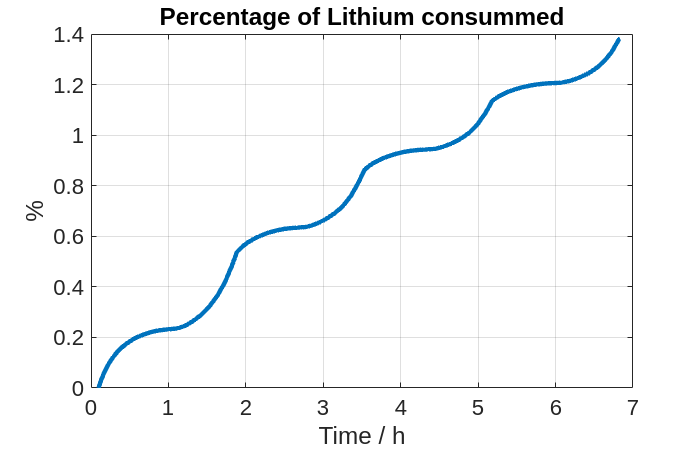

In [16]:
figure

capacity = computeCellCapacity(model);
F = PhysicalConstants.F;

qty  = quantities;
qty  = qty - qty(1);

plot(time/hour, 100 * (qty*F) / capacity);

title('Percentage of Lithium consummed');
xlabel('Time / h');
ylabel('%');
grid on;